In [ ]:
# IMPORT LIBRARIES
# ====================================
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix,
    ConfusionMatrixDisplay, roc_curve, roc_auc_score
)

In [ ]:
# STEP 1: LOAD AND CLEAN DATA
# ====================================
df = pd.read_csv("FloodPrediction.csv")

# Label encode the Station_Names column
df['Station_Names'] = LabelEncoder().fit_transform(df['Station_Names'])

# Replace null in 'Flood?' with 0
df['Flood?'] = df['Flood?'].fillna(0).astype(int)

# Check for missing values in each column
print(df.isnull().sum())

Sl                   0
Station_Names        0
Year                 0
Month                0
Max_Temp             0
Min_Temp             0
Rainfall             0
Relative_Humidity    0
Wind_Speed           0
Cloud_Coverage       0
Bright_Sunshine      0
Station_Number       0
X_COR                0
Y_COR                0
LATITUDE             0
LONGITUDE            0
ALT                  0
Period               0
Flood?               0
dtype: int64


In [ ]:
print(df.head())

   Sl  Station_Names  Year  Month  Max_Temp  Min_Temp  Rainfall  \
0   0              0  1949      1      29.4      12.3       0.0   
1   1              0  1949      2      33.9      15.2       9.0   
2   2              0  1949      3      36.7      20.2       8.0   
3   3              0  1949      4      33.9      23.9     140.0   
4   4              0  1949      5      35.6      25.0     217.0   

   Relative_Humidity  Wind_Speed  Cloud_Coverage  Bright_Sunshine  \
0               68.0    0.453704             0.6         7.831915   
1               63.0    0.659259             0.9         8.314894   
2               59.0    1.085185             1.5         8.131915   
3               71.0    1.772222             3.9         8.219149   
4               76.0    1.703704             4.1         7.046809   

   Station_Number     X_COR     Y_COR  LATITUDE  LONGITUDE  ALT   Period  \
0           41950  536809.8  510151.9      22.7      90.36    4  1949.01   
1           41950  536809.8  5

Flood?
0    16412
1     4132
Name: count, dtype: int64


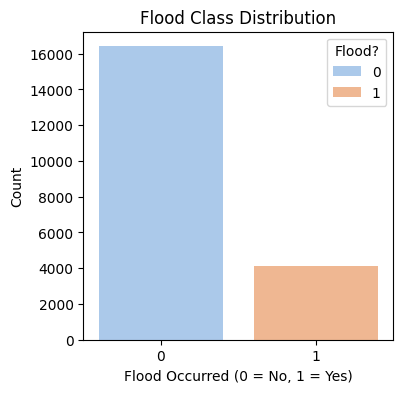

In [ ]:
# Balance check
print(df['Flood?'].value_counts())

# Plot class distribution
plt.figure(figsize=(4, 4))
sns.countplot(x='Flood?', hue='Flood?', data=df, palette='pastel')
plt.title("Flood Class Distribution")
plt.xlabel("Flood Occurred (0 = No, 1 = Yes)")
plt.ylabel("Count")
plt.show()

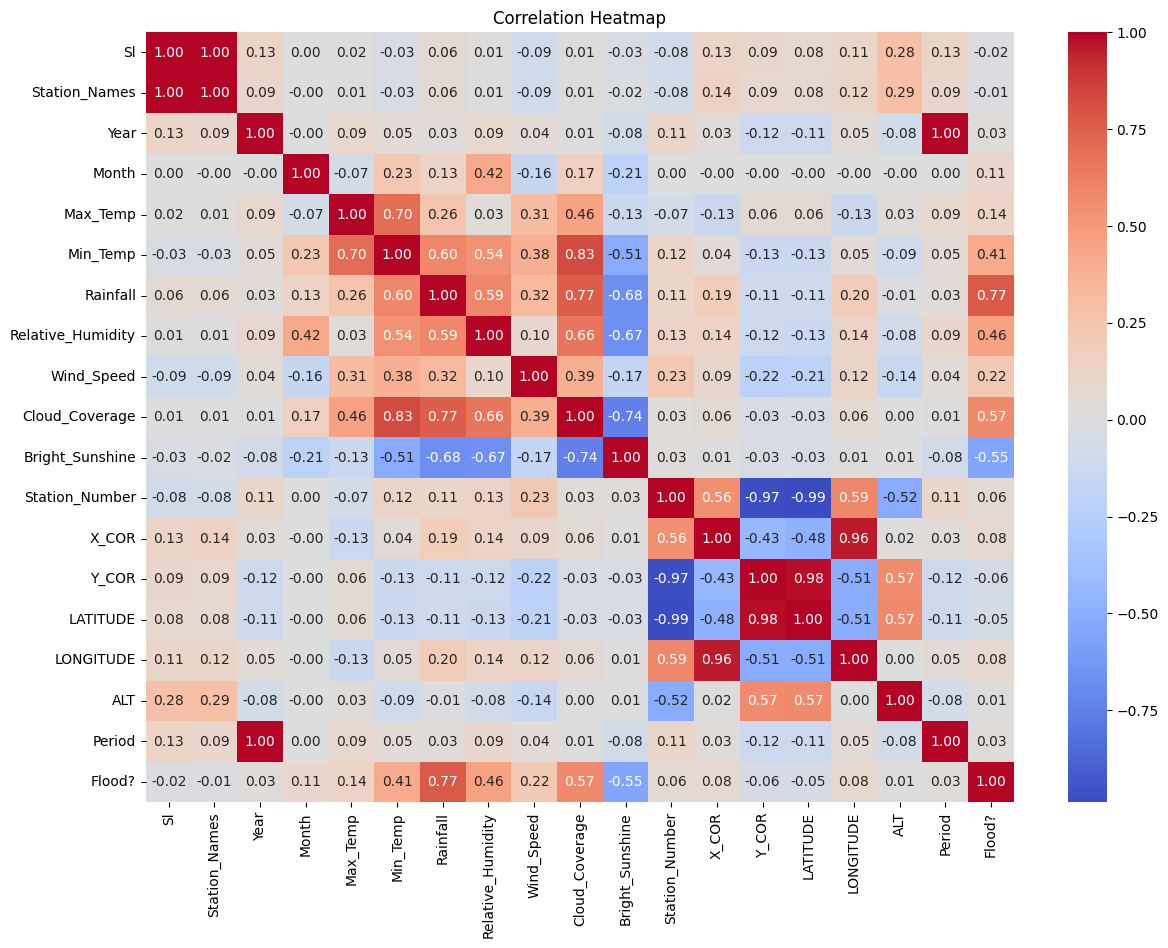

In [ ]:
# STEP 2: EDA (Exploratory Data Analysis)
# ====================================

# 1. Correlation Heatmap
plt.figure(figsize=(14, 10))
sns.heatmap(df.corr(), cmap='coolwarm', annot=True, fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()

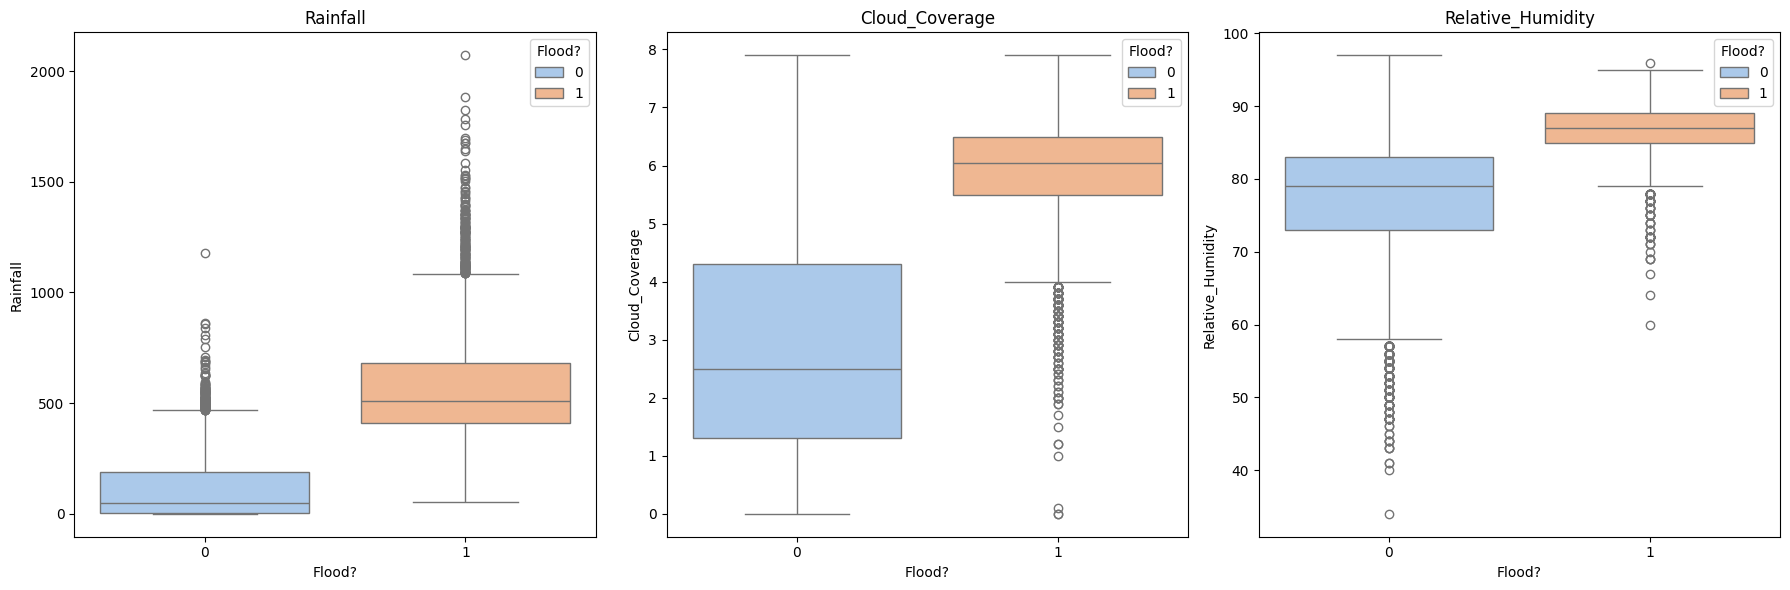

In [ ]:
# 2. Boxplots for selected features
plt.figure(figsize=(18, 6))
selected_features = ['Rainfall', 'Cloud_Coverage', 'Relative_Humidity']
for i, col in enumerate(selected_features, 1):
    plt.subplot(1, 3, i)
    sns.boxplot(x='Flood?', hue='Flood?', y=col, data=df, palette='pastel')
    plt.title(col)
plt.tight_layout()
plt.show()

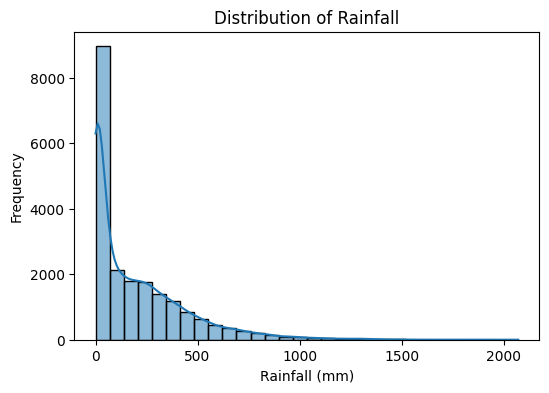

In [ ]:
# 3.Histogram of Rainfall
plt.figure(figsize=(6, 4))
sns.histplot(df['Rainfall'], bins=30, kde=True)
plt.title("Distribution of Rainfall")
plt.xlabel("Rainfall (mm)")
plt.ylabel("Frequency")
plt.show()

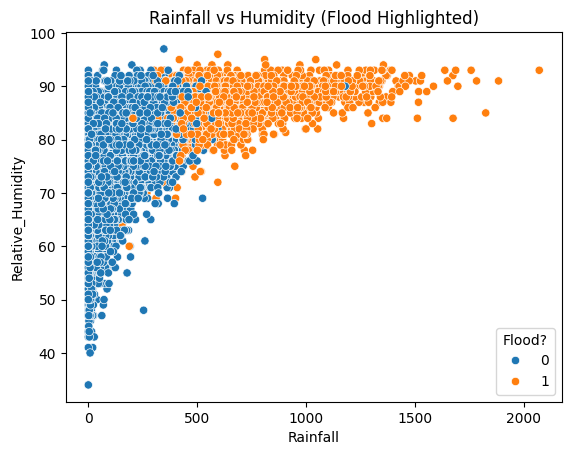

In [ ]:
# 4. Scatter Plot
sns.scatterplot(x='Rainfall', y='Relative_Humidity', hue='Flood?', data=df)
plt.title("Rainfall vs Humidity (Flood Highlighted)")
plt.show()

In [ ]:
# Drop unused columns
X = df.drop(columns=['Flood?', 'Sl', 'Period', 'Station_Number'])
y = df['Flood?']

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

After SMOTE: Counter({0: 13112, 1: 13112})


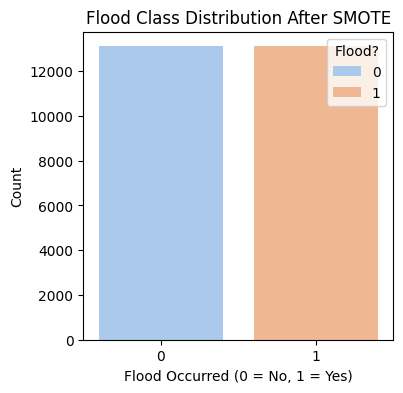

In [ ]:
smote = SMOTE(random_state=42)
X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)

# 4. Print new class distribution
print("After SMOTE:", Counter(y_train_sm))
df_smote = pd.DataFrame({'Flood?': y_train_sm})

# Plot
plt.figure(figsize=(4, 4))
sns.countplot(x='Flood?', hue='Flood?', data=df_smote, palette='pastel')
plt.title("Flood Class Distribution After SMOTE")
plt.xlabel("Flood Occurred (0 = No, 1 = Yes)")
plt.ylabel("Count")
plt.show()

In [ ]:
# ========== SINGLE-CORE ==========
start = time.time()
model1 = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=1)
model1.fit(X_train_sm, y_train_sm)
train_time_1 = time.time() - start

start = time.time()
pred1 = model1.predict(X_test)
latency_1 = (time.time() - start) / len(X_test) * 1000  # in milliseconds

accuracy_1 = accuracy_score(y_test, pred1)


In [ ]:
# ========== PARALLEL (MULTI-CORE) ==========
start = time.time()
model2 = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
model2.fit(X_train_sm, y_train_sm)
train_time_2 = time.time() - start

start = time.time()
pred2 = model2.predict(X_test)
latency_2 = (time.time() - start) / len(X_test) * 1000  # in milliseconds

accuracy_2 = accuracy_score(y_test, pred2)

In [ ]:
# ========== SHOW RESULTS ==========
print("\n--- Comparison ---\n")
print(f"Single-core   → Time: {train_time_1:.2f}s | Accuracy: {accuracy_1:.4f} | Latency: {latency_1:.4f} ms/sample")
print(f"Parallel-core → Time: {train_time_2:.2f}s | Accuracy: {accuracy_2:.4f} | Latency: {latency_2:.4f} ms/sample")


--- Comparison ---

Single-core   → Time: 4.55s | Accuracy: 0.9732 | Latency: 0.0111 ms/sample
Parallel-core → Time: 3.39s | Accuracy: 0.9732 | Latency: 0.0109 ms/sample


In [ ]:
# Classification Report
print("\nClassification Report:\n")
print(classification_report(y_test, pred1))



Classification Report:

              precision    recall  f1-score   support

           0       0.99      0.98      0.98      3300
           1       0.91      0.96      0.93       809

    accuracy                           0.97      4109
   macro avg       0.95      0.97      0.96      4109
weighted avg       0.97      0.97      0.97      4109



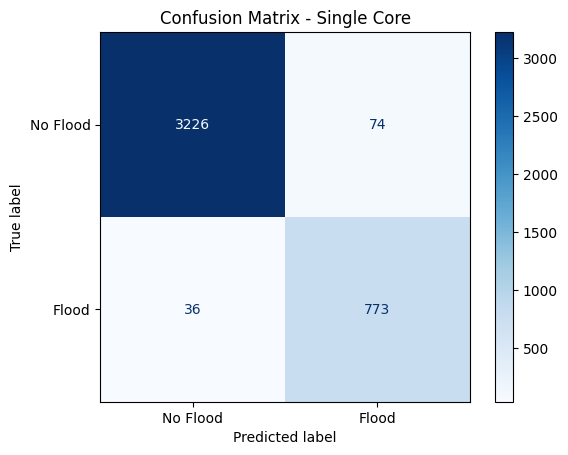

In [ ]:
# ========== CONFUSION MATRIX ==========
cm1 = confusion_matrix(y_test, pred1)
disp1 = ConfusionMatrixDisplay(confusion_matrix=cm1, display_labels=["No Flood", "Flood"])
disp1.plot(cmap="Blues")
plt.title("Confusion Matrix - Single Core")
plt.show()